In [1]:
import os

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import faiss
import torch
import umap
from ogb.nodeproppred import DglNodePropPredDataset
from sklearn.decomposition import PCA

Using backend: pytorch


In [3]:
dataset = DglNodePropPredDataset('ogbn-arxiv', root='../../data/dataset_dgl')
graph = dataset[0][0]
graph.add_edges(graph.edges()[1], graph.edges()[0])

In [4]:
MODEL_NB_NUMBER = 52
output_emb_file = f'../../models/graphsage_link_pred/full_graphsage_linkpred_{MODEL_NB_NUMBER}_h.npy'

In [5]:
embeddings = np.load(output_emb_file)
embeddings.shape

(169343, 50)

## L2 Distance

In [6]:
index = faiss.IndexFlatL2(embeddings.shape[1])

In [7]:
index.train(embeddings)
index.add(embeddings)

In [8]:
index

<faiss.swigfaiss.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7fe9b0761420> >

In [9]:
index.ntotal

169343

### Check if the closest embedding is a neighbor

In [10]:
distances, indices = index.search(embeddings, 2)

In [11]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(105081)

In [12]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [13]:
max_k = 100
distances, indices = index.search(embeddings, max_k + 1)

In [14]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [15]:
has_neighbor

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

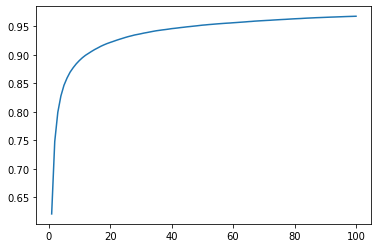

In [16]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [17]:
percentages

tensor([0.6205, 0.7478, 0.7992, 0.8278, 0.8466, 0.8594, 0.8697, 0.8776, 0.8844,
        0.8901, 0.8951, 0.8993, 0.9028, 0.9063, 0.9095, 0.9123, 0.9152, 0.9177,
        0.9199, 0.9218, 0.9237, 0.9256, 0.9274, 0.9290, 0.9307, 0.9323, 0.9336,
        0.9350, 0.9361, 0.9372, 0.9384, 0.9393, 0.9404, 0.9414, 0.9424, 0.9432,
        0.9439, 0.9446, 0.9453, 0.9462, 0.9467, 0.9474, 0.9481, 0.9487, 0.9493,
        0.9499, 0.9505, 0.9510, 0.9517, 0.9523, 0.9527, 0.9533, 0.9537, 0.9542,
        0.9546, 0.9550, 0.9554, 0.9558, 0.9561, 0.9565, 0.9569, 0.9573, 0.9577,
        0.9581, 0.9585, 0.9589, 0.9593, 0.9597, 0.9600, 0.9603, 0.9606, 0.9609,
        0.9613, 0.9616, 0.9619, 0.9622, 0.9625, 0.9628, 0.9632, 0.9635, 0.9637,
        0.9640, 0.9643, 0.9646, 0.9649, 0.9651, 0.9654, 0.9656, 0.9658, 0.9660,
        0.9663, 0.9665, 0.9666, 0.9668, 0.9670, 0.9672, 0.9675, 0.9676, 0.9678,
        0.9680])

In [18]:
percentages.max()

tensor(0.9680)

### Percentage of same class neighbors by neighborhood size

In [19]:
y = dataset[0][1][:, 0]

In [20]:
label_dict = {idx: val for idx, val in enumerate(y.numpy())}

In [21]:
label_transform = np.vectorize(label_dict.get)

In [22]:
ind_labels = label_transform(indices)

In [23]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [24]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [25]:
perc_same_class = n_same_class / n_total

In [26]:
perc_same_class

array([0.68876186, 0.67627832, 0.66713908, 0.65917989, 0.65305209,
       0.64740694, 0.64276139, 0.63859002, 0.63463241, 0.63132518,
       0.62830307, 0.62535702, 0.62267206, 0.62020742, 0.61797929,
       0.6157167 , 0.61365603, 0.61171377, 0.60988582, 0.60819993,
       0.60659304, 0.60502541, 0.60363055, 0.60227098, 0.60094908,
       0.59963551, 0.59839891, 0.59722132, 0.59606752, 0.59497253,
       0.59389485, 0.59284153, 0.59185902, 0.59090912, 0.58999528,
       0.58913484, 0.58828627, 0.58739208, 0.58658584, 0.58574609,
       0.58496041, 0.58421243, 0.58345914, 0.58274183, 0.5820362 ,
       0.58135983, 0.58069   , 0.58001844, 0.5793861 , 0.57875011,
       0.57812899, 0.57750326, 0.5769115 , 0.57630546, 0.57571824,
       0.57514366, 0.57459619, 0.57406453, 0.57352528, 0.57300912,
       0.57251085, 0.57199818, 0.57151912, 0.57101692, 0.57053172,
       0.57004414, 0.56954969, 0.56908473, 0.56864325, 0.56819372,
       0.56773955, 0.56731596, 0.56688715, 0.56645899, 0.56603

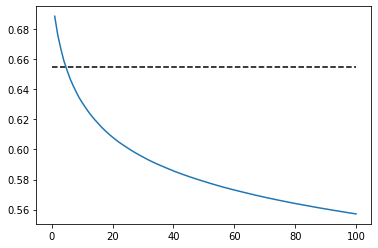

In [27]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Cossine Distance

In [28]:
emb_norm = embeddings / np.linalg.norm(embeddings, axis=1)[:, None]

In [29]:
index_cos = faiss.IndexFlatIP(emb_norm.shape[1])

In [30]:
index_cos.train(emb_norm)
index_cos.add(emb_norm)

In [31]:
index_cos

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7fe883bd3c00> >

In [32]:
index_cos.ntotal

169343

### Check if the closest embedding is a neighbor

In [33]:
distances, indices = index_cos.search(emb_norm, 2)

In [34]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(109290)

In [35]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [36]:
(sum(emb_norm[0] * emb_norm[411]) + 1) / 2

0.9202261317714147

In [37]:
max_k = 1000
distances, indices = index_cos.search(emb_norm, max_k + 1)

In [38]:
indices

array([[     0,  10839,  79872, ..., 129489, 100019, 141323],
       [     1, 154949, 100594, ...,   5293, 142584, 123338],
       [     2, 123185, 113232, ...,  85017, 106263,  26175],
       ...,
       [169340,  18094,   2618, ...,  31053,  85636, 166908],
       [169341,  43672,  71093, ...,  75050,  73662, 154359],
       [169342, 127946,  17652, ...,  55508,  39403, 154764]])

In [39]:
sum(emb_norm[0] * emb_norm[411])

0.8404522635428293

In [40]:
distances

array([[1.        , 0.99064094, 0.98598695, ..., 0.87459326, 0.8745913 ,
        0.8745513 ],
       [1.        , 0.99760234, 0.9819091 , ..., 0.43425062, 0.43404672,
        0.43396205],
       [0.99999976, 0.9750812 , 0.970123  , ..., 0.74482137, 0.74470943,
        0.74450916],
       ...,
       [1.        , 0.9555734 , 0.9536438 , ..., 0.69150484, 0.69125986,
        0.6912019 ],
       [0.99999994, 0.97993004, 0.977874  , ..., 0.84573615, 0.8456772 ,
        0.84558946],
       [0.9999999 , 0.9507055 , 0.94013494, ..., 0.5730424 , 0.57297033,
        0.5727588 ]], dtype=float32)

In [41]:
has_neighbor = torch.zeros((emb_norm.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [42]:
has_neighbor

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

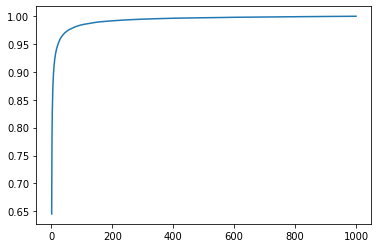

In [43]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [44]:
percentages

tensor([0.6454, 0.7744, 0.8271, 0.8560, 0.8745, 0.8869, 0.8971, 0.9052, 0.9118,
        0.9173, 0.9221, 0.9261, 0.9300, 0.9331, 0.9358, 0.9384, 0.9409, 0.9430,
        0.9448, 0.9463, 0.9481, 0.9496, 0.9512, 0.9527, 0.9540, 0.9555, 0.9566,
        0.9577, 0.9588, 0.9598, 0.9608, 0.9617, 0.9625, 0.9633, 0.9641, 0.9648,
        0.9654, 0.9661, 0.9668, 0.9674, 0.9680, 0.9685, 0.9691, 0.9697, 0.9700,
        0.9705, 0.9710, 0.9714, 0.9719, 0.9723, 0.9727, 0.9732, 0.9736, 0.9740,
        0.9744, 0.9747, 0.9750, 0.9753, 0.9756, 0.9759, 0.9762, 0.9764, 0.9767,
        0.9770, 0.9773, 0.9776, 0.9779, 0.9781, 0.9784, 0.9787, 0.9789, 0.9792,
        0.9794, 0.9797, 0.9798, 0.9801, 0.9803, 0.9805, 0.9807, 0.9809, 0.9811,
        0.9813, 0.9815, 0.9816, 0.9819, 0.9821, 0.9823, 0.9824, 0.9826, 0.9828,
        0.9829, 0.9830, 0.9832, 0.9833, 0.9835, 0.9836, 0.9838, 0.9839, 0.9840,
        0.9841, 0.9843, 0.9844, 0.9846, 0.9847, 0.9848, 0.9849, 0.9850, 0.9851,
        0.9851, 0.9853, 0.9854, 0.9855, 

### Percentage of same class neighbors by neighborhood size

In [45]:
ind_labels = label_transform(indices)

In [46]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [47]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [48]:
perc_same_class = n_same_class / n_total

In [49]:
perc_same_class

array([0.68918113, 0.6766533 , 0.6672808 , 0.65940133, 0.65281588,
       0.64717368, 0.64235478, 0.63812425, 0.63420723, 0.63072403,
       0.62761593, 0.62477437, 0.6221097 , 0.61960889, 0.6172313 ,
       0.61504572, 0.61290295, 0.61102778, 0.6091368 , 0.60747507,
       0.60592154, 0.60444402, 0.60297328, 0.60160837, 0.60030754,
       0.59900502, 0.59787138, 0.59676451, 0.59562687, 0.59453535,
       0.59351997, 0.5925184 , 0.59158076, 0.59061612, 0.58971217,
       0.58884188, 0.58796915, 0.58712479, 0.58633434, 0.58554782,
       0.58480904, 0.58407732, 0.58336781, 0.5826346 , 0.58192912,
       0.58125546, 0.58057165, 0.57994106, 0.57931813, 0.5786887 ,
       0.57807295, 0.57750848, 0.57691652, 0.57633149, 0.57581047,
       0.5752623 , 0.57471574, 0.57418997, 0.5736606 , 0.57315458,
       0.57263844, 0.57215114, 0.57168981, 0.5711998 , 0.57074822,
       0.57031104, 0.56985817, 0.56940508, 0.56897565, 0.56852736,
       0.56811939, 0.56769725, 0.56728902, 0.56689254, 0.56649

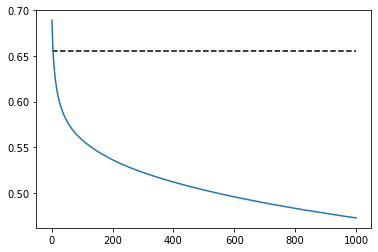

In [50]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

### Percentage of same class neighbors by angular section

In [51]:
distance_list = np.linspace(0.99, 0.5, 50)
distance_list

array([0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91, 0.9 , 0.89,
       0.88, 0.87, 0.86, 0.85, 0.84, 0.83, 0.82, 0.81, 0.8 , 0.79, 0.78,
       0.77, 0.76, 0.75, 0.74, 0.73, 0.72, 0.71, 0.7 , 0.69, 0.68, 0.67,
       0.66, 0.65, 0.64, 0.63, 0.62, 0.61, 0.6 , 0.59, 0.58, 0.57, 0.56,
       0.55, 0.54, 0.53, 0.52, 0.51, 0.5 ])

In [52]:
perc_section_same_class = np.zeros(distance_list.shape)
n_section_neighbors = np.zeros(distance_list.shape)
n_section_same_class = np.zeros(distance_list.shape)
for idx, dist in enumerate(distance_list):
    n_section_neighbors[idx] = (distances > dist)[:, 1:].sum()
    n_section_same_class[idx] = (is_same_class * (distances > dist)[:, 1:]).sum()
    perc_section_same_class[idx] = n_section_same_class[idx] / n_section_neighbors[idx]
perc_section_same_class

array([0.64781854, 0.71912724, 0.73774499, 0.74083379, 0.73874471,
       0.73404952, 0.72903598, 0.72423931, 0.71926304, 0.71478238,
       0.71034427, 0.70595538, 0.70147724, 0.69737239, 0.69369594,
       0.69037307, 0.6871725 , 0.68376467, 0.68016642, 0.67623884,
       0.67185837, 0.66713782, 0.66197155, 0.65655279, 0.65087767,
       0.64511539, 0.63943008, 0.63380398, 0.62829791, 0.62291795,
       0.61772277, 0.61264708, 0.60767132, 0.60282496, 0.59802173,
       0.59325751, 0.58855508, 0.58387005, 0.57917077, 0.57440704,
       0.56958385, 0.5646526 , 0.55960047, 0.55444789, 0.54916427,
       0.54369858, 0.53809268, 0.53233762, 0.52644285, 0.5204102 ])

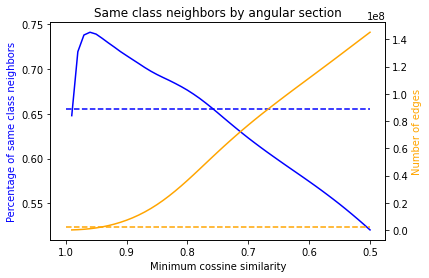

In [53]:
fig, ax1 = plt.subplots()
ax1.set_title('Same class neighbors by angular section')
ax1.set_ylabel('Percentage of same class neighbors', color='blue')
ax1.set_xlabel('Minimum cossine similarity')
ax1.invert_xaxis()
ax1.plot(distance_list, perc_section_same_class, color='blue')
ax1.hlines(0.6551, 1, 0.5, color='blue', ls='--')

ax2 = ax1.twinx()
ax2.set_ylabel('Number of edges', color='orange')
ax2.plot(distance_list, n_section_neighbors, color='orange')
ax2.hlines(graph.edges()[0].shape[0], 1, 0.5, color='orange', ls='--')

#### Evaluating a single threshold

In [54]:
thresh = 0.8

Number of isolated nodes

In [55]:
(((distances > thresh)[:, 1:] * 1)[:,0] == 0).sum()

580

Number of connected nodes

In [56]:
(((distances > thresh)[:, 1:] * 1)[:,0] == 1).sum()

168763

Number of edges

In [57]:
((distances > thresh)[:, 1:] * 1).sum()

36466931

Number of edges in the graph - Undirected

In [58]:
graph.edges()[0].shape[0]

2332486

Degree distribution

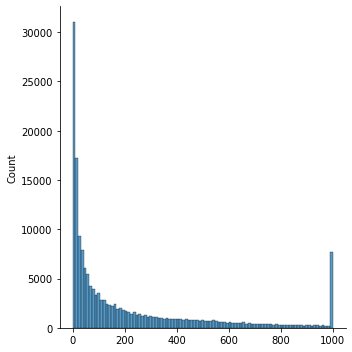

In [59]:
degree_dist = ((distances > thresh)[:, 1:] * 1).sum(axis=1)
sns.displot(degree_dist)

## Inner Product

In [60]:
index_ip = faiss.IndexFlatIP(embeddings.shape[1])

In [61]:
index_ip.train(embeddings)
index_ip.add(embeddings)

In [62]:
index_ip

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7fe8818cc330> >

In [63]:
index_ip.ntotal

169343

### Check if the closest embedding is a neighbor

In [64]:
distances, indices = index_ip.search(embeddings, 2)

In [65]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(15700)

In [66]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [67]:
(sum(embeddings[0] * embeddings[411]) + 1) / 2

6.750132202520035

In [68]:
max_k = 100
distances, indices = index_ip.search(embeddings, max_k + 1)

In [69]:
indices

array([[ 35094,  98391, 107601, ...,   3358,  63569,  56932],
       [100594,      1,  73227, ..., 156329, 144753,  92159],
       [109883, 161700, 109034, ...,  88884, 102026, 134600],
       ...,
       [ 25696,  35094,  29393, ...,  46522, 138369, 104947],
       [ 35094, 107601, 162023, ..., 162885,  85553,  73770],
       [141488,  43848,  13442, ...,  54705,  53364, 116648]])

In [70]:
sum(embeddings[0] * embeddings[411])

12.50026440504007

In [71]:
distances

array([[20.584337 , 15.554187 , 14.886941 , ..., 11.708078 , 11.706969 ,
        11.695376 ],
       [41.956898 , 36.731735 , 36.355846 , ..., 26.461653 , 26.452911 ,
        26.4411   ],
       [33.00413  , 32.793476 , 32.646015 , ..., 29.185125 , 29.182842 ,
        29.180887 ],
       ...,
       [21.627666 , 19.714249 , 18.131422 , ..., 14.055824 , 14.055172 ,
        14.049276 ],
       [14.445244 , 11.391989 , 11.2375   , ...,  7.532836 ,  7.5311613,
         7.5286956],
       [39.577343 , 39.5369   , 39.46453  , ..., 27.125187 , 27.10969  ,
        27.108778 ]], dtype=float32)

In [72]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [73]:
has_neighbor

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

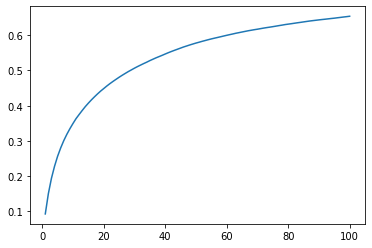

In [74]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [75]:
percentages

tensor([0.0927, 0.1503, 0.1938, 0.2278, 0.2563, 0.2799, 0.3006, 0.3185, 0.3346,
        0.3494, 0.3632, 0.3749, 0.3863, 0.3972, 0.4071, 0.4165, 0.4252, 0.4335,
        0.4414, 0.4486, 0.4558, 0.4625, 0.4688, 0.4748, 0.4807, 0.4863, 0.4916,
        0.4968, 0.5016, 0.5065, 0.5110, 0.5153, 0.5196, 0.5236, 0.5279, 0.5319,
        0.5358, 0.5393, 0.5429, 0.5467, 0.5504, 0.5538, 0.5571, 0.5603, 0.5635,
        0.5668, 0.5696, 0.5724, 0.5751, 0.5778, 0.5801, 0.5827, 0.5850, 0.5873,
        0.5895, 0.5916, 0.5936, 0.5957, 0.5977, 0.5998, 0.6017, 0.6036, 0.6057,
        0.6074, 0.6092, 0.6109, 0.6127, 0.6142, 0.6158, 0.6171, 0.6187, 0.6203,
        0.6217, 0.6230, 0.6243, 0.6258, 0.6273, 0.6287, 0.6303, 0.6315, 0.6327,
        0.6340, 0.6353, 0.6365, 0.6379, 0.6391, 0.6404, 0.6415, 0.6425, 0.6436,
        0.6446, 0.6455, 0.6465, 0.6475, 0.6484, 0.6496, 0.6506, 0.6517, 0.6528,
        0.6539])

### Percentage of same class neighbors by neighborhood size

In [76]:
ind_labels = label_transform(indices)

In [77]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [78]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [79]:
perc_same_class = n_same_class / n_total

In [80]:
perc_same_class

array([0.39585929, 0.38111702, 0.37402786, 0.37193005, 0.37532227,
       0.37689384, 0.37734994, 0.37757539, 0.37735247, 0.37714815,
       0.37675605, 0.37625214, 0.37580623, 0.37523505, 0.37459988,
       0.37387617, 0.37331542, 0.37284026, 0.37232499, 0.37185505,
       0.37141552, 0.37103555, 0.37059772, 0.37014939, 0.36971614,
       0.36925353, 0.36890873, 0.36856726, 0.36824853, 0.36789967,
       0.36753884, 0.36724005, 0.36692769, 0.36668738, 0.36640749,
       0.36614888, 0.36589101, 0.36562418, 0.36534377, 0.36509732,
       0.36482097, 0.36459139, 0.36432017, 0.36407563, 0.36383212,
       0.36360099, 0.36338724, 0.36316185, 0.36295674, 0.36274402,
       0.362502  , 0.36231551, 0.3621179 , 0.36189284, 0.36170075,
       0.36151648, 0.36128698, 0.36110021, 0.36092138, 0.36074161,
       0.36056416, 0.36039462, 0.36023975, 0.36006637, 0.35988142,
       0.35969564, 0.35951796, 0.35935281, 0.35918371, 0.35902526,
       0.35887435, 0.35872993, 0.3585724 , 0.3584145 , 0.35826

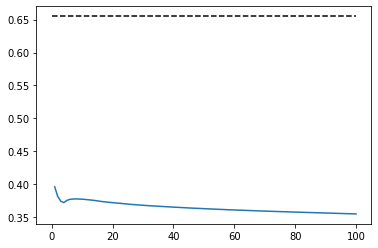

In [81]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Scatter Plot PCA 2dim

In [82]:
pca = PCA(n_components=2)

In [83]:
pca.fit(embeddings)

PCA(n_components=2)

In [84]:
emb_2d = pca.transform(embeddings)

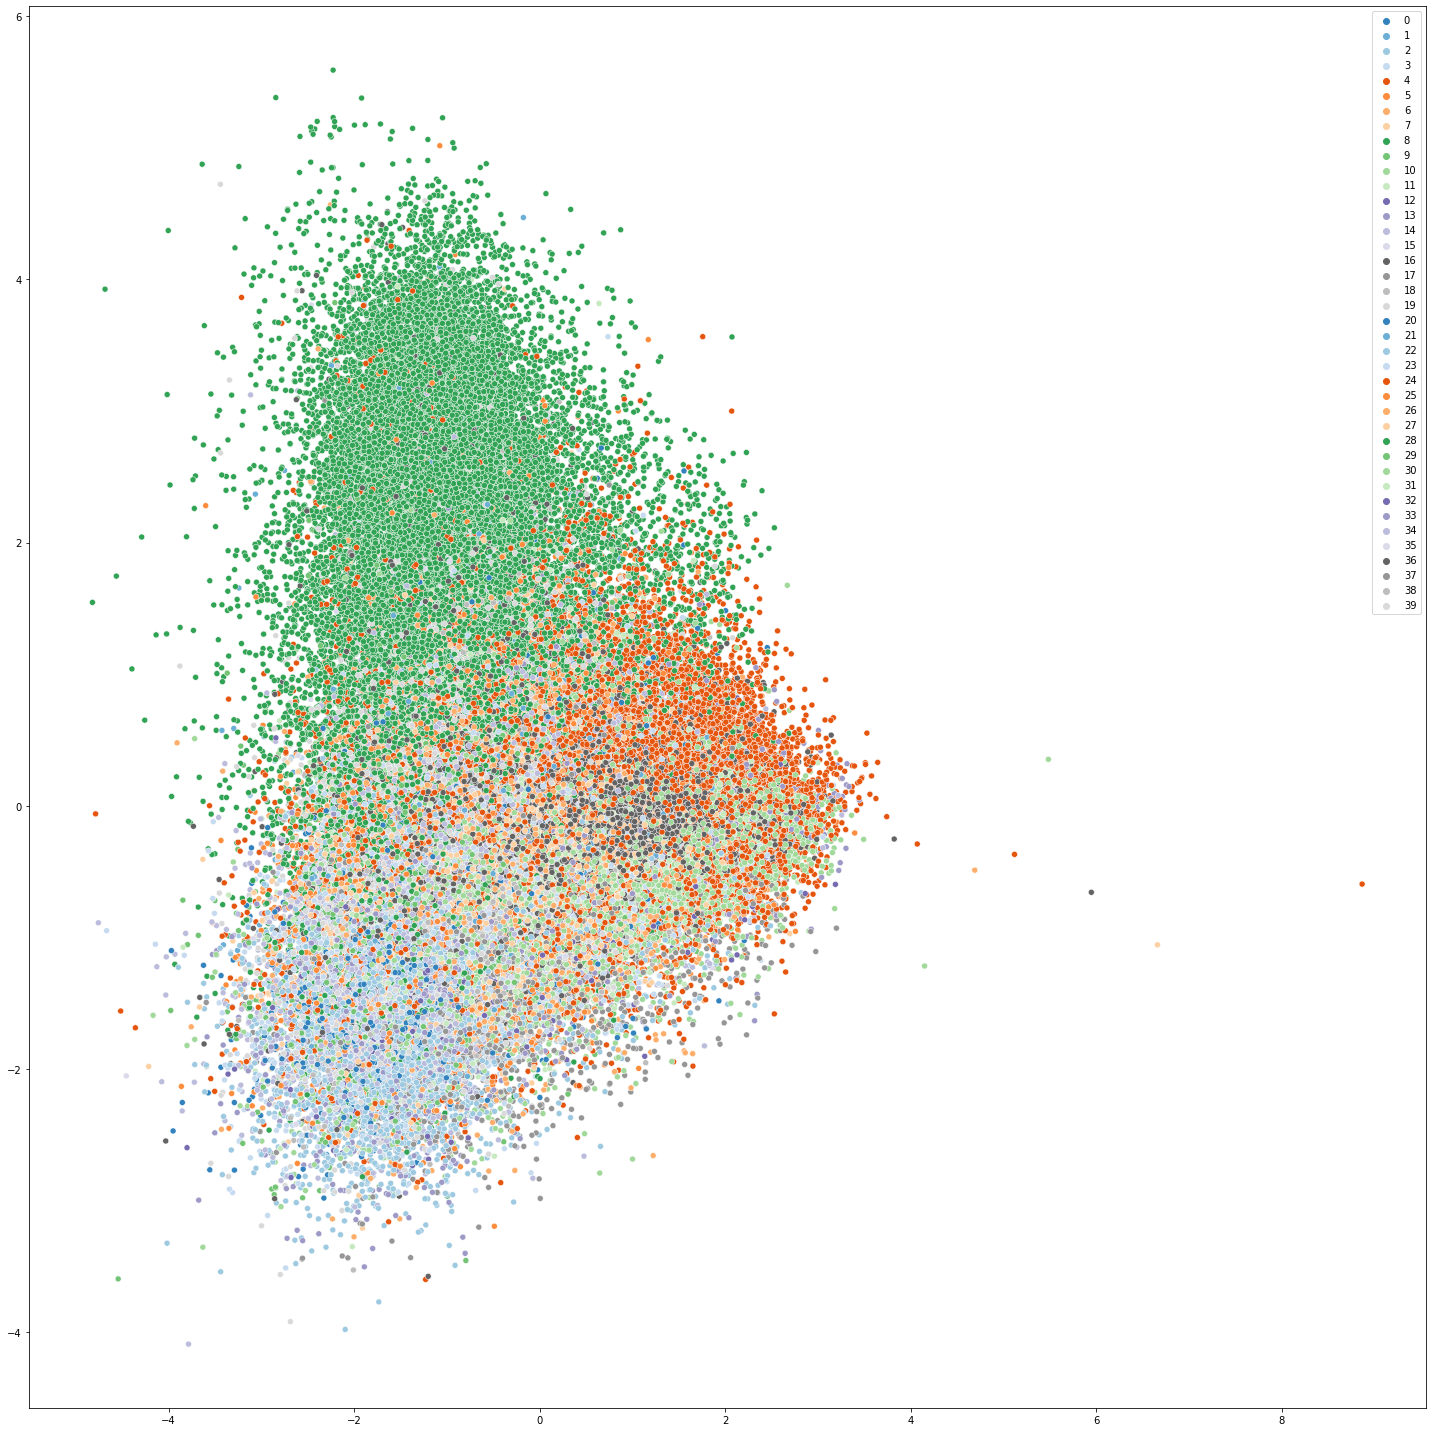

In [85]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d

In [86]:
emb_umap_2d = umap.UMAP(n_components=2).fit_transform(embeddings)

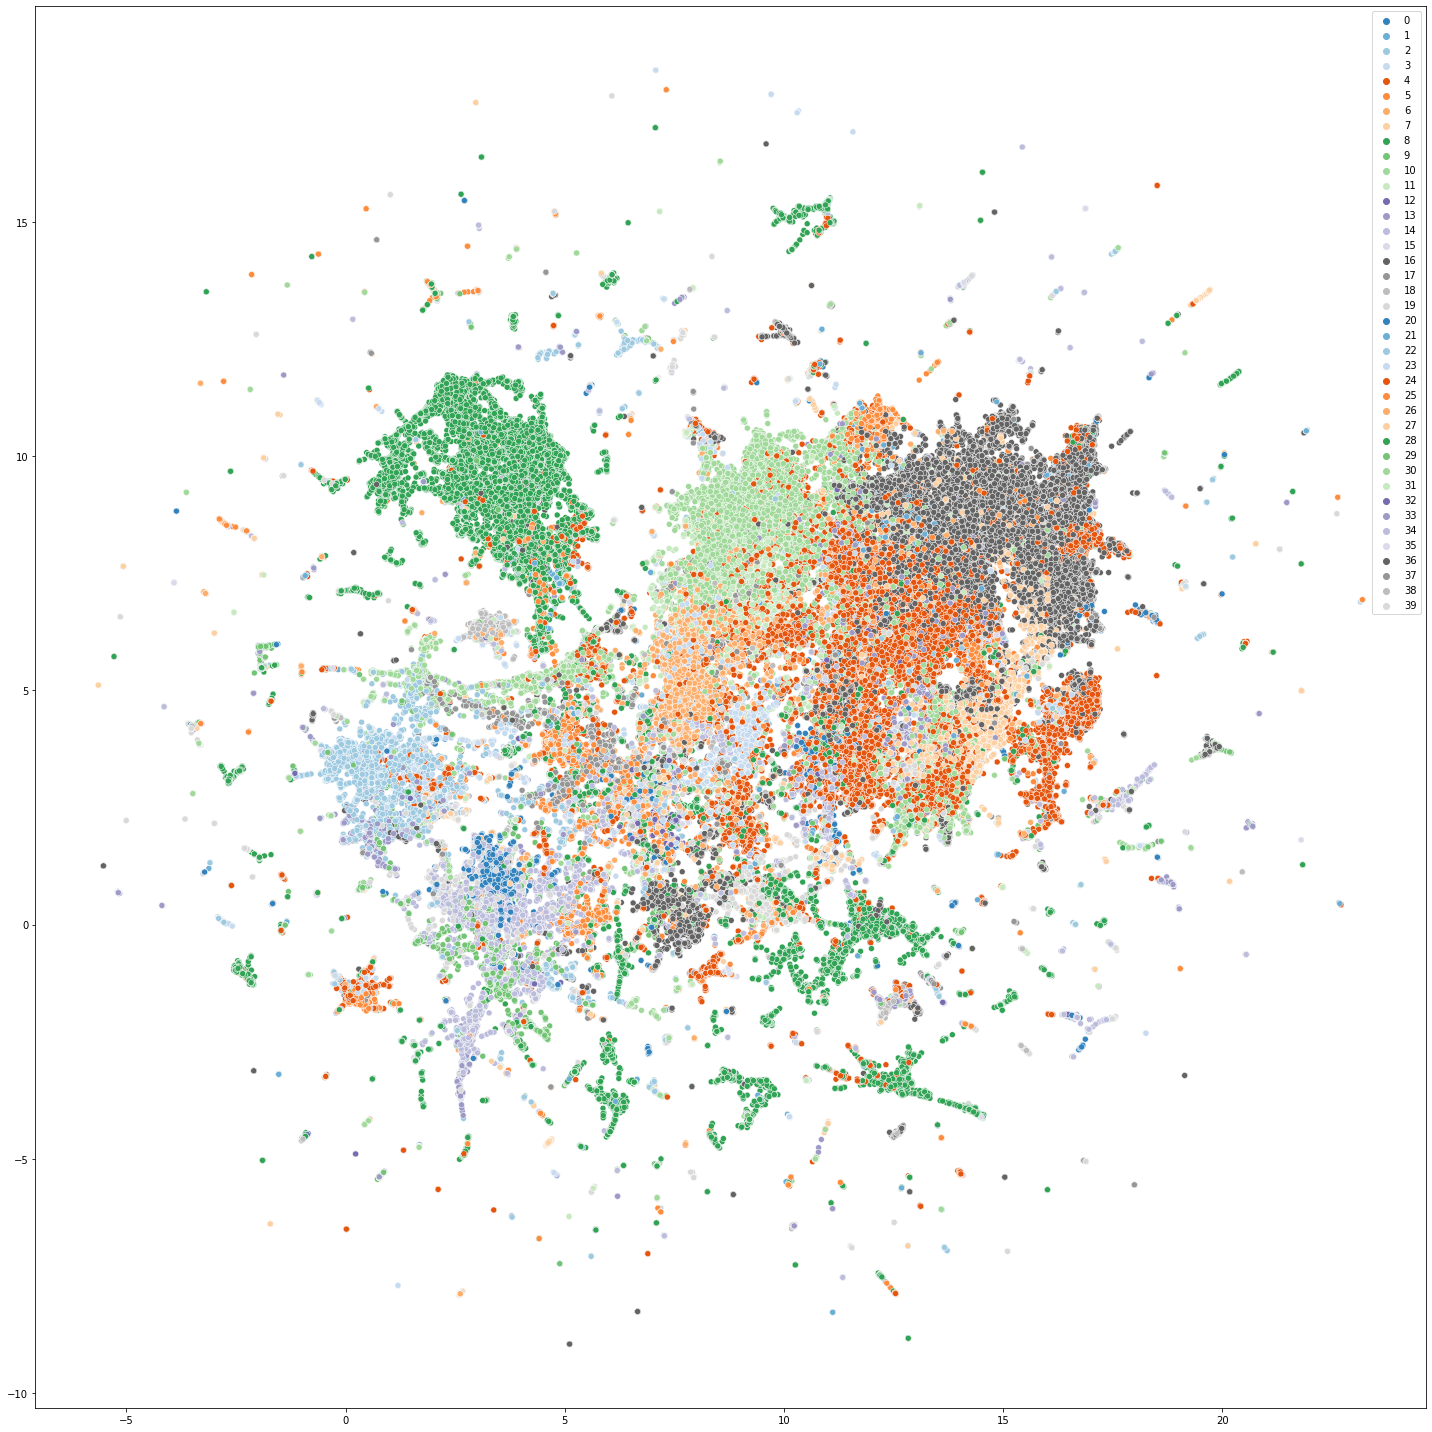

In [87]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d[:,0], y=emb_umap_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d - Normalized embeddings

In [88]:
emb_umap_2d_norm = umap.UMAP(n_components=2).fit_transform(emb_norm)

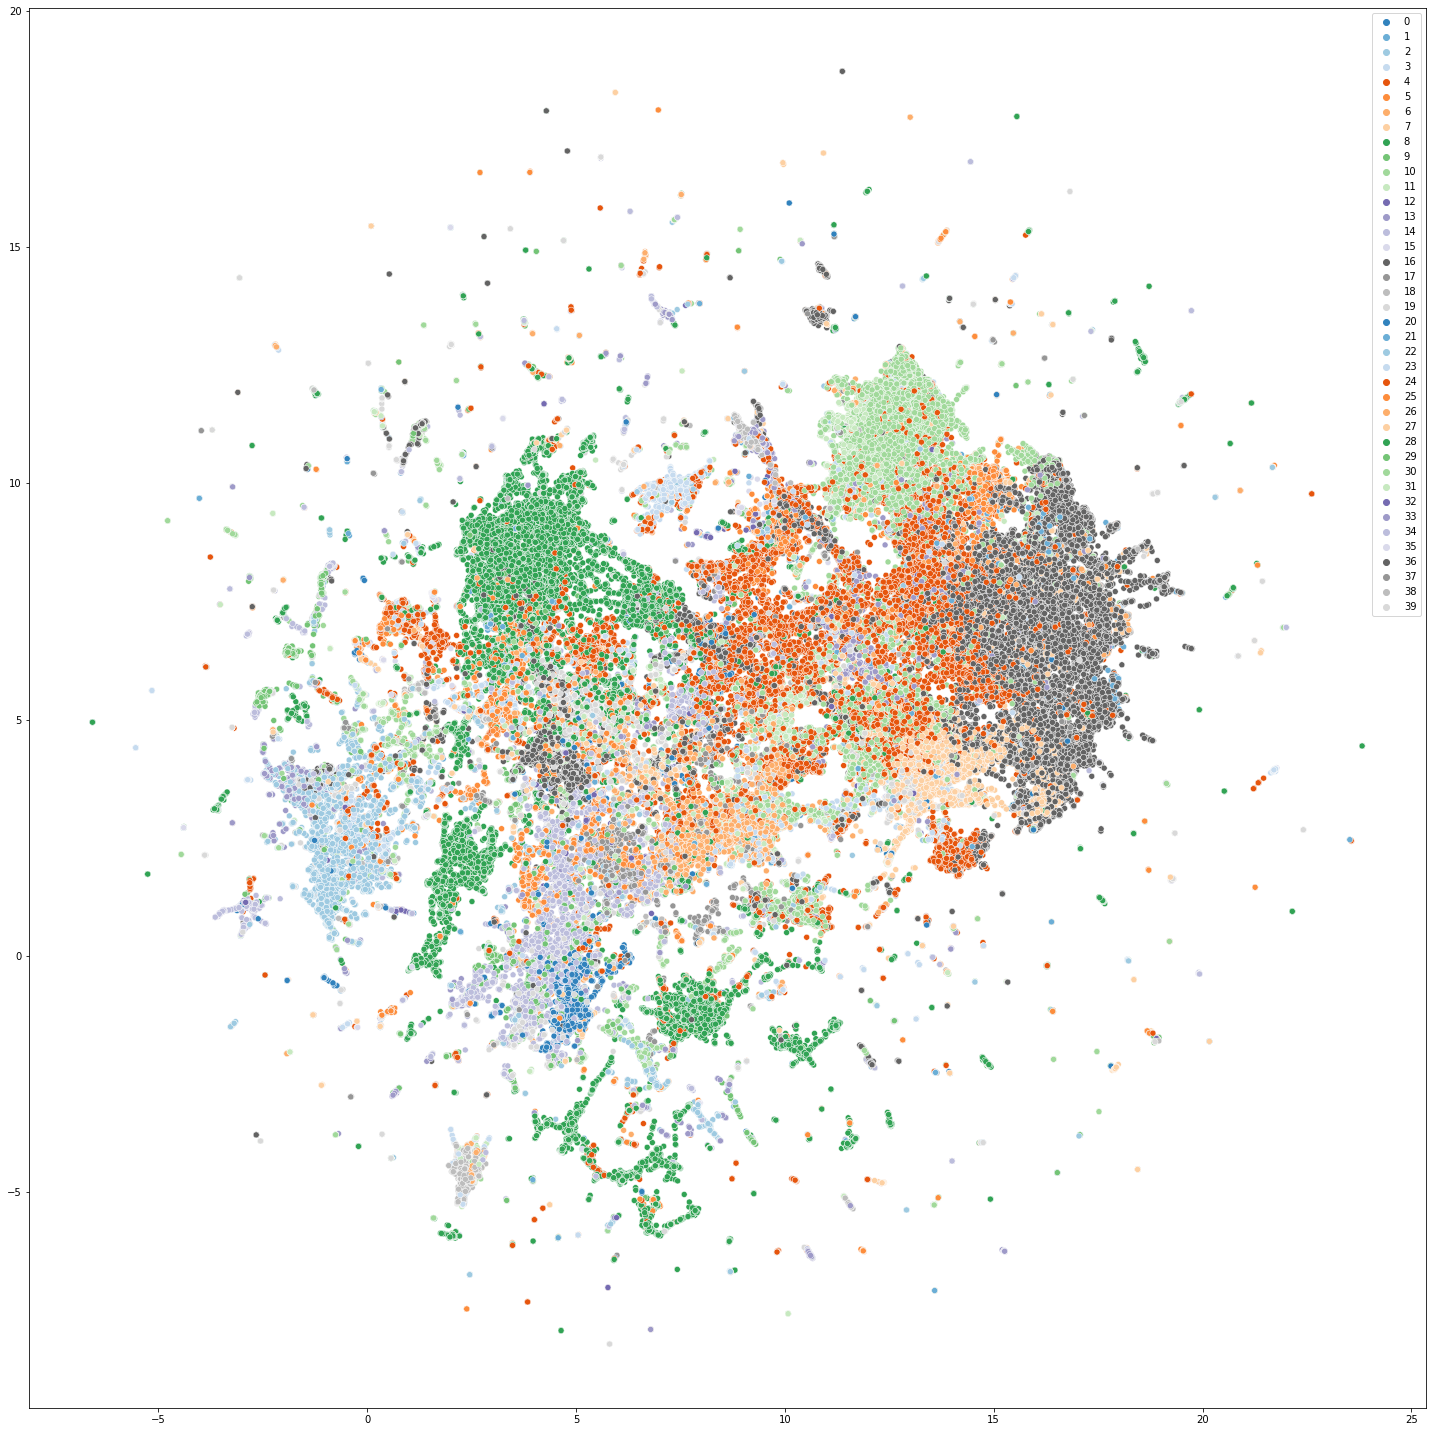

In [89]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d_norm[:,0], y=emb_umap_2d_norm[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()